In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikeras rdkit-pypi tdqm catboost
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/2. TRAINING/2. Deep Learning/Tensorflow - source code")

# **1. Visualize Model Training History in Keras**

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow_addons as tfa

df = pd.read_csv('Data/HIV integrase.csv', )

# Add column for activity
df["active"] = np.zeros(len(df))
# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
df.loc[df[df['pChEMBL Value'] >= 7].index, "active"] = 1.0
df.drop(['Unnamed: 0', 'Molecule ChEMBL ID','pChEMBL Value'], axis =1, inplace = True)
df.head(5)


# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# split into input (X) and output (Y) variables
X = df.drop(['active'], axis =1)
y = df['active']

# create model
model = Sequential()
model.add(Dense(1024, input_dim=X.shape[1], kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(512, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[tfa.metrics.FBetaScore(num_classes=2,average='micro',threshold=0.5)])
# Fit the model
history = model.fit(X, y, validation_split=0.2, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
62/62 [==============================] - 2s 8ms/step - loss: 0.3340 - fbeta_score: 0.7516 - val_loss: 0.2101 - val_fbeta_score: 0.1818
Epoch 2/200
62/62 [==============================] - 0s 5ms/step - loss: 0.1727 - fbeta_score: 0.8680 - val_loss: 0.1758 - val_fbeta_score: 0.3396
Epoch 3/200
62/62 [==============================] - 0s 5ms/step - loss: 0.1251 - fbeta_score: 0.9179 - val_loss: 0.1856 - val_fbeta_score: 0.2400
Epoch 4/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0946 - fbeta_score: 0.9326 - val_loss: 0.2009 - val_fbeta_score: 0.2105
Epoch 5/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0768 - fbeta_score: 0.9487 - val_loss: 0.1747 - val_fbeta_score: 0.3043
Epoch 6/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0705 - fbeta_score: 0.9523 - val_loss: 0.1482 - val_fbeta_score: 0.3913
Epoch 7/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0517 - fbeta_score: 0.9580 - val_loss: 0.17

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'fbeta_score', 'val_loss', 'val_fbeta_score'])


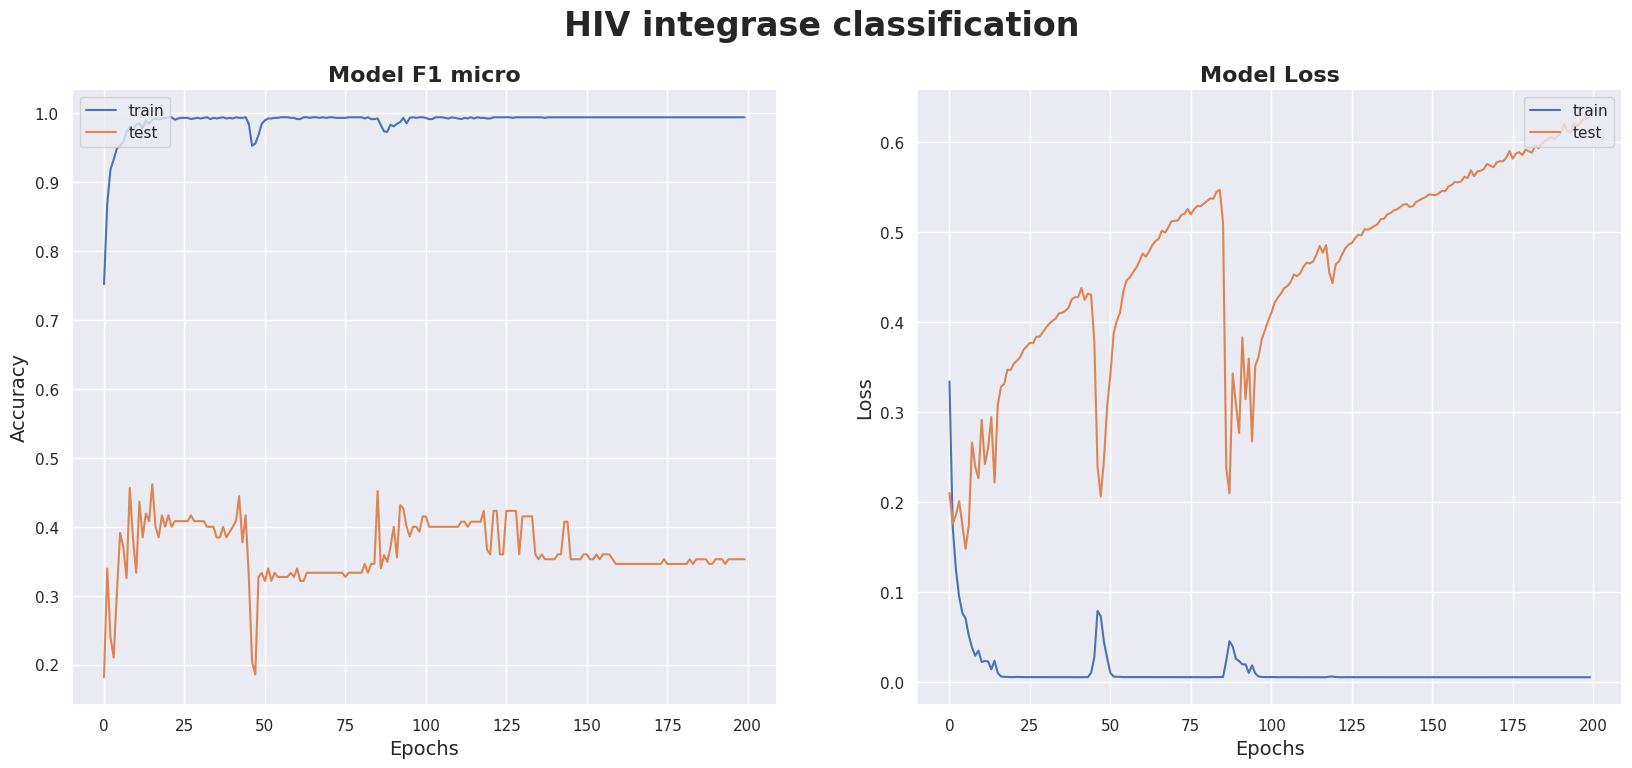

In [ ]:
# summarize history for accuracy
import seaborn as sns
sns.set()
plt.figure(figsize = (20,8))
plt.suptitle("HIV integrase classification", fontsize = 24, weight = 'bold')
plt.subplot(121)
plt.plot(history.history[ 'fbeta_score' ])
plt.plot(history.history[ 'val_fbeta_score' ])
plt.title( 'Model F1 micro', fontsize = 16, weight = 'semibold')
plt.ylabel( 'Accuracy', fontsize = 14 )
plt.xlabel( 'Epochs', fontsize = 14)
plt.legend([ 'train' ,  'test' ], loc= 'upper left' )

# summarize history for loss
plt.subplot(122)
plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'Model Loss' , fontsize = 16, weight = 'semibold')
plt.ylabel( 'Loss', fontsize = 14)
plt.xlabel( 'Epochs', fontsize = 14)
plt.legend([ 'train' ,  'test' ], loc= 'upper right' )
plt.show()

# **2. Dropout Regularization For Neural Networks**


## 2.1. Baseline model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.constraints import maxnorm      # contrains weight
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
# 1. import data
df = pd.read_csv('Data/HIV integrase.csv', )

# Add column for activity
df["active"] = np.zeros(len(df))
# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
df.loc[df[df['pChEMBL Value'] >= 7].index, "active"] = 1.0
df.drop(['Unnamed: 0', 'Molecule ChEMBL ID','pChEMBL Value'], axis =1, inplace = True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,active
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


Baseline: 90.31% (1.49%)


<Axes: >

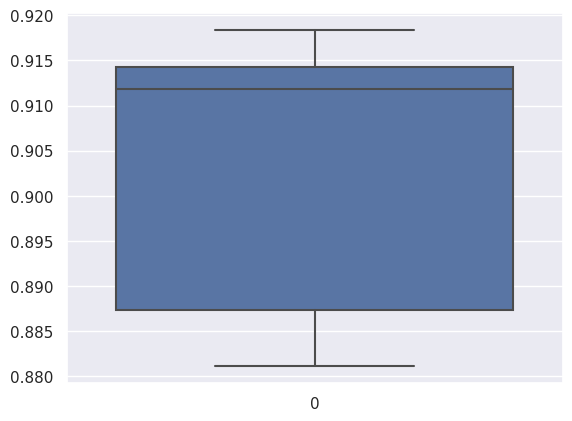

In [ ]:
# 2. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 3. split into input (X) and output (Y) variables
X = df.drop(['active'], axis =1)
y = df['active']

# 4. encode class values as integers


# 5. creatue baseline model
def create_baseline():
  # create
  model = Sequential()
  model.add(Dense(60, activation = 'relu', kernel_initializer= 'normal', input_dim =X.shape[1]))
  model.add(Dense(30, activation = 'relu', kernel_initializer= 'normal'))
  model.add(Dense(1, activation = 'sigmoid', kernel_initializer= 'normal'))
  # Compile model
  #sgd = SGD(learning_rate = .01, momentum = .8, decay = 0.0, nesterov = False)
  model.compile(loss = 'binary_crossentropy',optimizer= 'adam' , metrics=[ 'accuracy' ] )
  return model

# evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_baseline, epochs=200, batch_size=32, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X,y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
sns.boxplot(results)

## 2.2. Using Dropout on the Visible Layer

In [ ]:
from keras.constraints import maxnorm


Visible: 86.02% (5.60%)


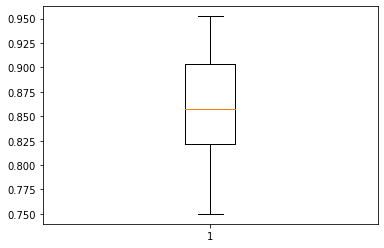

In [ ]:
# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = df.drop(['active'], axis =1)
y = df['active']

# 3. encode class values as integers: ROCK AND MINE



# 3. dropout in the input layer with weight constraint
def create_model_vis():
  # create
  model = Sequential()
  model.add(Dropout(0.2, input_shape=(X.shape,)))
  model.add(Dense(60, activation = 'relu', kernel_initializer= 'normal', kernel_constraint= maxnorm(3))) # maxnorm
  model.add(Dense(30, activation = 'relu', kernel_initializer= 'normal', kernel_constraint= maxnorm(3)))
  model.add(Dense(1, activation = 'sigmoid', kernel_initializer= 'normal'))
  # Compile model
  sgd = SGD(learning_rate=0.01, momentum=0.8, decay=0.0, nesterov=False)
  model.compile(loss = 'binary_crossentropy',optimizer= sgd , metrics=[ 'accuracy' ] )
  return model

# 4. evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_model_vis, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Visible: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
plt.boxplot(results)
plt.show()

## 2.3. Using Dropout on Hidden Layers

Hidden: 87.48% (8.61%)


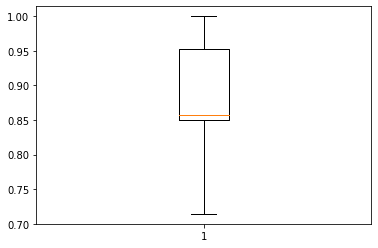

In [ ]:
# dropout in hidden layers with weight constraint
def create_model_hid():
  # create
  model = Sequential()
  model.add(Dense(60, input_dim = 60, activation='relu', kernel_initializer= 'normal', kernel_constraint=maxnorm(3)))
  model.add(Dropout(0.1))

  model.add(Dense(30, activation='relu', kernel_initializer= 'normal', kernel_constraint=maxnorm(3)))
  model.add(Dropout(0.1))
  
  model.add(Dense(1, activation='sigmoid', kernel_initializer= 'normal'))
  # Compile model
  sgd = SGD(learning_rate=0.01, momentum=0.8, decay=0.0, nesterov=False)
  model.compile(loss = 'binary_crossentropy',optimizer= sgd , metrics=[ 'accuracy' ] )
  return model

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# evaluate model with standardized dataset
estimators = []
estimators.append(( 'standardize' , StandardScaler()))
estimators.append(( 'mlp' , KerasClassifier(model=create_model_hid, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Hidden: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
plt.boxplot(results)
plt.show()

# **3. Learning rate**

## 3.1. Time-Based Learning Rate Schedule

Learning rate = Learning rate * 1/(1+ decay x epoch)

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Dataset/ionosphere.csv', header = None)
dataframe.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453,g


In [ ]:
# Time Based Learning Rate Decay
import pandas as pd
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# load dataset
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/ionosphere.csv', header = None)


# split into input (X) and output (Y) variables
X = dataset.iloc[:,0:34]
Y = dataset.iloc[:,34]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

# create model
model = Sequential()
model.add(Dense(34, input_dim = 34, kernel_initializer= 'normal', activation ='relu'))
model.add(Dense(1, kernel_initializer=  'normal', activation ='sigmoid'))

# Compile model
epochs = 150
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss= 'binary_crossentropy' , optimizer=sgd, metrics=[ 'accuracy' ])

# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=epochs, batch_size=28, verbose=2)

Epoch 1/150
9/9 - 2s - loss: 0.6798 - accuracy: 0.7234 - val_loss: 0.6331 - val_accuracy: 0.7155 - 2s/epoch - 179ms/step
Epoch 2/150
9/9 - 0s - loss: 0.6363 - accuracy: 0.7191 - val_loss: 0.5344 - val_accuracy: 0.7069 - 134ms/epoch - 15ms/step
Epoch 3/150
9/9 - 0s - loss: 0.5547 - accuracy: 0.7830 - val_loss: 0.4745 - val_accuracy: 0.9052 - 101ms/epoch - 11ms/step
Epoch 4/150
9/9 - 0s - loss: 0.4597 - accuracy: 0.8298 - val_loss: 0.3050 - val_accuracy: 0.9569 - 140ms/epoch - 16ms/step
Epoch 5/150
9/9 - 0s - loss: 0.3929 - accuracy: 0.8638 - val_loss: 0.2525 - val_accuracy: 0.9569 - 187ms/epoch - 21ms/step
Epoch 6/150
9/9 - 0s - loss: 0.3113 - accuracy: 0.8894 - val_loss: 0.3097 - val_accuracy: 0.9310 - 147ms/epoch - 16ms/step
Epoch 7/150
9/9 - 0s - loss: 0.2707 - accuracy: 0.8851 - val_loss: 0.2325 - val_accuracy: 0.9483 - 177ms/epoch - 20ms/step
Epoch 8/150
9/9 - 0s - loss: 0.2381 - accuracy: 0.9149 - val_loss: 0.2117 - val_accuracy: 0.9483 - 134ms/epoch - 15ms/step
Epoch 9/150
9/9 - 

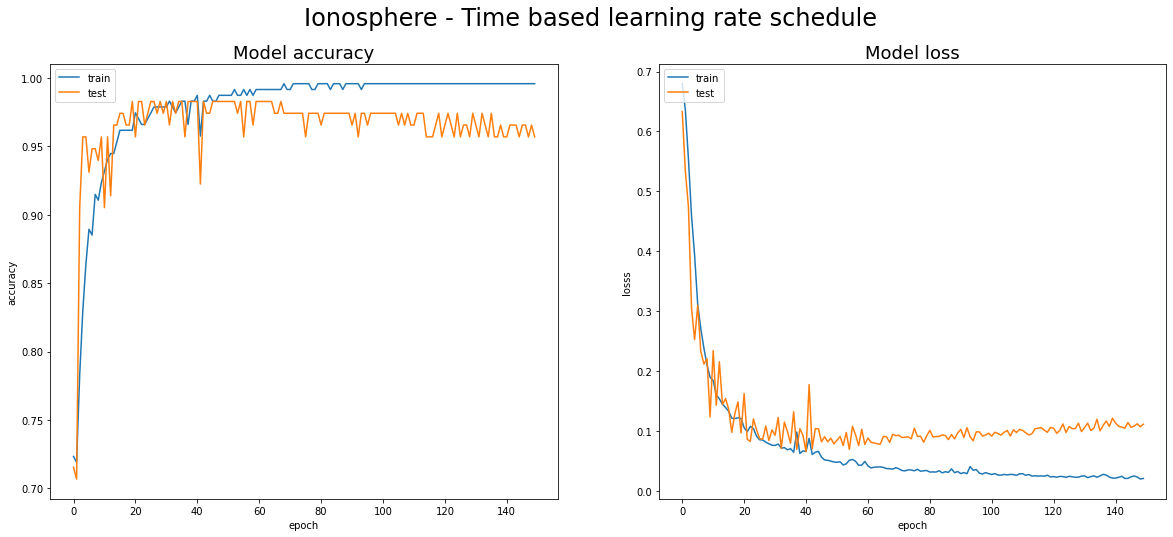

In [ ]:
# summarize history for accuracy
plt.figure(figsize = (20,8))
plt.suptitle("Ionosphere - Time based learning rate schedule", fontsize = 24)
plt.subplot(121)
plt.plot(history.history[ 'accuracy' ])
plt.plot(history.history[ 'val_accuracy' ])
plt.title( 'Model accuracy', fontsize = 18 )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'test' ], loc= 'upper left' )
# summarize history for loss
plt.subplot(122)
plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'Model loss' , fontsize = 18)
plt.ylabel( 'losss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'test' ], loc= 'upper left' )
plt.savefig('Test.png', dpi = 600, transparent = True)
plt.show()

## 3.2. Drop-Based Learning Rate Schedule

LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)

In [ ]:
from matplotlib.ticker import LogFormatter
# Drop-Based Learning Rate Decay
import pandas as pd
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
# 1. learning rate schedule
def step_decay(epoch):
  initial_lrate = .1
  drop = .5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/(epochs_drop)))
  return lrate

# 2. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 3. load dataset
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/ionosphere.csv', header = None)

# 4. split into input (X) and output (Y) variables
X = dataset.iloc[:,0:34]
Y = dataset.iloc[:,34]

# 5. encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

# 6. create model
model = Sequential()
model.add(Dense(34, input_dim = 34, kernel_initializer= 'normal', activation ='relu'))
model.add(Dense(1, kernel_initializer=  'normal', activation ='sigmoid'))

# 7. Compile model
sgd = SGD(learning_rate =0.0, momentum=0.9, decay=0.0, nesterov=False)
model.compile(loss= 'binary_crossentropy' , optimizer=sgd, metrics=[ 'accuracy' ])

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=100, batch_size=28,
    callbacks=callbacks_list, verbose=2)

Epoch 1/100
9/9 - 1s - loss: 0.6785 - accuracy: 0.7234 - val_loss: 0.6203 - val_accuracy: 0.7069 - lr: 0.1000 - 760ms/epoch - 84ms/step
Epoch 2/100
9/9 - 0s - loss: 0.6261 - accuracy: 0.7191 - val_loss: 0.5146 - val_accuracy: 0.7241 - lr: 0.1000 - 61ms/epoch - 7ms/step
Epoch 3/100
9/9 - 0s - loss: 0.4885 - accuracy: 0.8255 - val_loss: 0.3413 - val_accuracy: 0.9310 - lr: 0.1000 - 61ms/epoch - 7ms/step
Epoch 4/100
9/9 - 0s - loss: 0.3599 - accuracy: 0.8681 - val_loss: 0.1692 - val_accuracy: 0.9569 - lr: 0.1000 - 82ms/epoch - 9ms/step
Epoch 5/100
9/9 - 0s - loss: 0.3007 - accuracy: 0.8809 - val_loss: 0.1301 - val_accuracy: 0.9569 - lr: 0.1000 - 62ms/epoch - 7ms/step
Epoch 6/100
9/9 - 0s - loss: 0.2138 - accuracy: 0.8936 - val_loss: 0.2238 - val_accuracy: 0.9483 - lr: 0.1000 - 82ms/epoch - 9ms/step
Epoch 7/100
9/9 - 0s - loss: 0.1762 - accuracy: 0.9191 - val_loss: 0.1252 - val_accuracy: 0.9741 - lr: 0.1000 - 62ms/epoch - 7ms/step
Epoch 8/100
9/9 - 0s - loss: 0.1530 - accuracy: 0.9489 - val

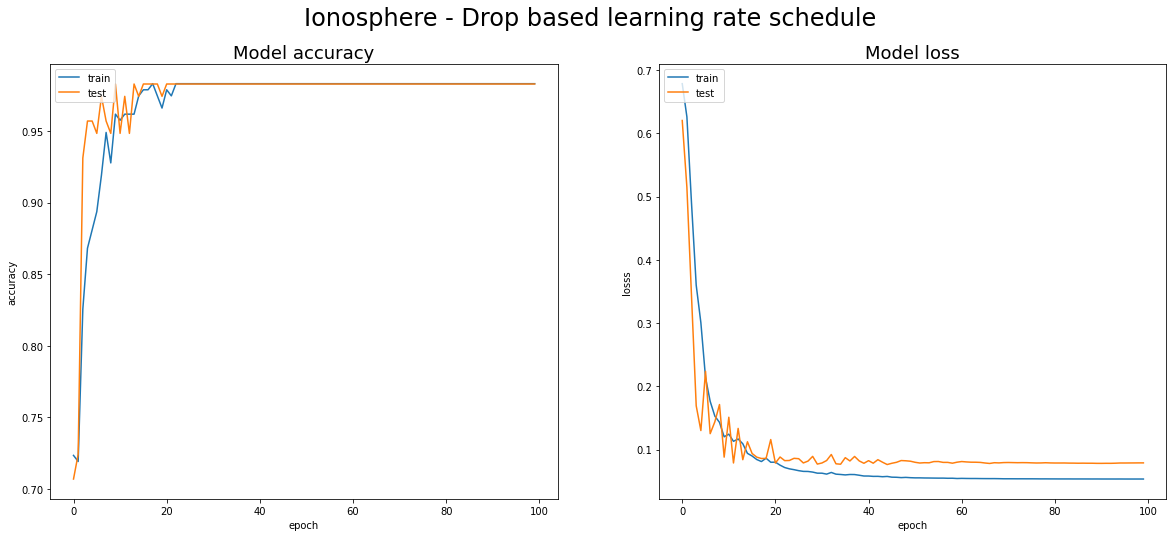

In [ ]:
# summarize history for accuracy
plt.figure(figsize = (20,8))
plt.suptitle("Ionosphere - Drop based learning rate schedule", fontsize = 24)
plt.subplot(121)
plt.plot(history.history[ 'accuracy' ])
plt.plot(history.history[ 'val_accuracy' ])
plt.title( 'Model accuracy', fontsize = 18 )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'test' ], loc= 'upper left' )

# summarize history for loss
plt.subplot(122)
plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'Model loss' , fontsize = 18)
plt.ylabel( 'losss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' ,  'test' ], loc= 'upper left' )
plt.show()

# **4. Save and load model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import tensorflow
import numpy as np
import os
import pandas as pd


# 1. fix random seed for reproducibility
np.random.seed(42)
tensorflow.random.set_seed(42)

# 2. load pima indians dataset
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/pima-indians-diabetes.csv')

# 3. split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

# 4. create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# 5. Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
# 6. Fit the model
model.fit(X, Y, epochs=150, batch_size=10,validation_split=0.33, verbose = 0)

# 7. evaluate the model
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 76.01%


## 4.1. SAVE

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## 4.2. LOAD

In [ ]:
json_file = open( 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
# evaluate loaded model on test data
loaded_model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 76.01%


# **5. Checkpointing Neural Network Models**

## 5.1. Checkpoint with improvement

In [ ]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

col = ['Number of times pregnant', 'Plasma glu', 'Diastolic blood pressure', 'Triceps skin fold thickness', 
       '2-Hour serum insulin', 'BMI', 'Diabetes pedigree function', 'Age', 'Class']
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/pima-indians-diabetes.csv', header = None, names = col)
dataset.head(5)

,Number of times pregnant,Plasma glu,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,BMI,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

# 3. create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# 4. Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

# 5. checkpoint
filepath = 'weights-imporvemet-{epoch:02d}-{val_accuracy: .2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callback_list = [checkpoint]

# Fit the model
model.fit(X, Y, epochs=150, batch_size=10,validation_split=0.33,callbacks=callbacks_list, verbose=0)

In [ ]:

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy' , verbose=1, save_best_only=True,
    mode= 'max' )
callbacks_list = [checkpoint]

# Fit the model
model.fit(X, Y, epochs=150, batch_size=10,validation_split=0.33,callbacks=callbacks_list, verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.67323, saving model to weights-improvement-01-0.67.hdf5

Epoch 00002: val_accuracy did not improve from 0.67323

Epoch 00003: val_accuracy did not improve from 0.67323

Epoch 00004: val_accuracy improved from 0.67323 to 0.67717, saving model to weights-improvement-04-0.68.hdf5

Epoch 00005: val_accuracy did not improve from 0.67717

Epoch 00006: val_accuracy improved from 0.67717 to 0.69291, saving model to weights-improvement-06-0.69.hdf5

Epoch 00007: val_accuracy did not improve from 0.69291

Epoch 00008: val_accuracy did not improve from 0.69291

Epoch 00009: val_accuracy did not improve from 0.69291

Epoch 00010: val_accuracy did not improve from 0.69291

Epoch 00011: val_accuracy did not improve from 0.69291

Epoch 00012: val_accuracy did not improve from 0.69291

Epoch 00013: val_accuracy did not improve from 0.69291

Epoch 00014: val_accuracy did not improve from 0.69291

Epoch 00015: val_accuracy did not improve from 0.69291



## 5.2. Checkpoint Best Neural Network Model Only

In [ ]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd


# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# 2. split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

# 3. create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# 4. Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])

# 5. checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy' , verbose=1, save_best_only=True,
    mode= 'max' )
callbacks_list = [checkpoint]

# 6. Fit the model
model.fit(X, Y, epochs=150, batch_size=10,validation_split=0.33,callbacks=callbacks_list, verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.67323, saving model to weights.best.hdf5

Epoch 00002: val_accuracy did not improve from 0.67323

Epoch 00003: val_accuracy did not improve from 0.67323

Epoch 00004: val_accuracy improved from 0.67323 to 0.67717, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.67717

Epoch 00006: val_accuracy improved from 0.67717 to 0.69291, saving model to weights.best.hdf5

Epoch 00007: val_accuracy did not improve from 0.69291

Epoch 00008: val_accuracy did not improve from 0.69291

Epoch 00009: val_accuracy did not improve from 0.69291

Epoch 00010: val_accuracy did not improve from 0.69291

Epoch 00011: val_accuracy did not improve from 0.69291

Epoch 00012: val_accuracy did not improve from 0.69291

Epoch 00013: val_accuracy did not improve from 0.69291

Epoch 00014: val_accuracy did not improve from 0.69291

Epoch 00015: val_accuracy did not improve from 0.69291

Epoch 00016: val_accuracy did not improve fro

## 5.3. Loading a Saved Neural Network Model

In [ ]:
# 1. fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# 2. split into input (X) and output (Y) variables
X = dataset.iloc[:,0:8]
Y = dataset.iloc[:,8]

# 3. create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(8, kernel_initializer= 'uniform' , activation= 'relu' ))
model.add(Dense(1, kernel_initializer= 'uniform' , activation= 'sigmoid' ))

# 4. load weights
model.load_weights("weights.best.hdf5")

# Compile model
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
print("Created model and loaded weights from file")
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
accuracy: 76.82%
